# Neural Network Experiments

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

In [31]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_raw = pd.read_sql_query("""
	select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	ifnull(fires_rollup.prior_fire_0_1_year, 0) as prior_fire_0_1_year,
	ifnull(fires_rollup.prior_fire_1_2_year, 0) as prior_fire_1_2_year,
	ifnull(fires_rollup.prior_fire_2_3_year, 0) as prior_fire_2_3_year,
	ifnull(fires_rollup.prior_fire_3_4_year, 0) as prior_fire_3_4_year,
	ifnull(fires_rollup.prior_fire_4_5_year, 0) as prior_fire_4_5_year,

  ifnull(fires_rollup.fire_size_class, '') as fire_size_class
from weather_geo
inner join soil
  on soil.fips = weather_geo.fips
left outer join fires_rollup
  on fires_rollup.date = weather_geo.date
  and fires_rollup.long = weather_geo.long
  and fires_rollup.lat = weather_geo.lat
	and fires_rollup.cause in ('Other causes', 'Natural', 'Power', 'Recreation')
where
	weather_geo.date >= '2008-01-01'
	and weather_geo.date < '2010-01-01'
	and weather_geo.day in (1, 8, 15, 22, 28) -- remove once models are stable
""", conn)

conn.close()

df_raw['date'] = df_raw['date'].astype('datetime64[ns]')

df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fips,83277.0,6057.877193,33.761007,6001.00,6029.000000,6057.000000,6087.000000,6115.000000
month,83277.0,6.522930,3.448724,1.00,4.000000,7.000000,10.000000,12.000000
year,83277.0,2006.501027,1.118346,2005.00,2006.000000,2007.000000,2008.000000,2008.000000
precipitation,83277.0,1.684698,5.544391,0.00,0.000000,0.010000,0.330000,104.520000
pressure,83277.0,94.069435,6.086902,73.90,91.020000,96.000000,98.980000,103.240000
humidity_2m,83277.0,5.779621,1.963660,0.64,4.340000,5.720000,7.150000,17.940000
temp_2m,83277.0,13.879346,8.070981,-16.26,8.310000,13.470000,19.720000,41.390000
temp_dew_point_2m,83277.0,3.944862,5.720350,-23.10,0.280000,4.680000,8.270000,23.010000
temp_wet_bulb_2m,83277.0,3.997204,5.645449,-21.63,0.340000,4.700000,8.270000,23.010000
temp_max_2m,83277.0,20.827836,9.850577,-13.80,13.530000,20.140000,28.400000,49.910000


In [35]:
df_fire_false = df_raw[df_raw.is_fire == 0]
df_fire_true = df_raw[df_raw.is_fire == 1]
print(f'Unbalanced classes of NO fire: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_fire_true_balanced = df_fire_true.sample(n=len(df_fire_false), replace=True)

df_fires = pd.concat([df_fire_false, df_fire_true_balanced], axis=0)
df_fire_false = df_fires[df_fires.is_fire == 0]
df_fire_true = df_fires[df_fires.is_fire == 1]
print(f'Balanced classes of NO fires: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_raw.date = pd.to_datetime(df_raw.date)
df_raw['day_of_week'] = df_raw.date.dt.dayofweek

X = df_fires.drop(['date', 'is_fire'], axis=1)

Unbalanced classes of NO fire: 73,325 and YES fire: 9,952
Balanced classes of NO fires: 73,325 and YES fire: 73,325


In [36]:
y = df_fires.is_fire.values

num_fires = (y == 1).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie Balanced)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

73325 fires out of 146650 data points
No fires 50.0% of the time (ie Balanced)


### Tensor flow for Max Temp

In [37]:
temp_max = np.array(X.temp_max_2m)

temp_max_normalizer = layers.Normalization(axis=None)
temp_max_normalizer.adapt(np.array(temp_max))

ValueError: in user code:

    File "/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_preprocessing_layer.py", line 117, in adapt_step  *
        self._adapt_maybe_build(data)
    File "/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_preprocessing_layer.py", line 280, in _adapt_maybe_build  **
        self.build(data_shape)
    File "/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/keras/layers/preprocessing/normalization.py", line 150, in build
        raise ValueError(

    ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None], with unknown axis at index: 0


In [26]:
temp_max_model = tf.keras.Sequential([
    temp_max_normalizer,
    layers.Dense(units=1, activation='sigmoid')
])

temp_max_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [27]:
temp_max_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall()]
)

In [28]:
%%time
history = temp_max_model.fit(
    X_encoded.temp_max_2m,
    y,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 45.8 s, sys: 5.46 s, total: 51.3 s
Wall time: 35.9 s


        loss    recall  val_loss  val_recall  epoch
95  0.621245  0.282555  1.029738    0.075264     95
96  0.620783  0.286978  1.000129    0.131453     96
97  0.620493  0.279928  0.834680    0.359942     97
98  0.621806  0.282416  0.845549    0.327182     98
99  0.621325  0.291816  0.858320    0.267883     99


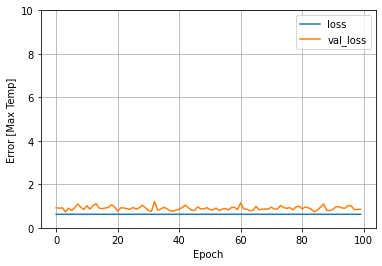

In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Max Temp]')
  plt.legend()
  plt.grid(True)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

plot_loss(history)

In [37]:
x_temp_max = tf.linspace(0, -50, 50)
y_temp_max = np.concatenate(temp_max_model.predict(x_temp_max)).ravel()

print(x_temp_max.shape)
print(y_temp_max.shape)

(50,)
(50,)


(188882,)
[False  True  True ...  True  True  True]


ValueError: x and y must be the same size

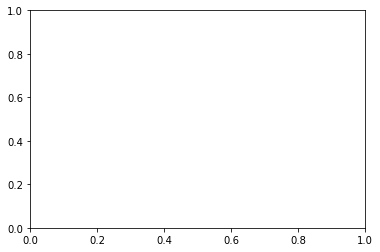

In [59]:
def plot_max_temp(x_plot, y_plot):
  plt.scatter(df_fires.temp_max_2m, y_train, label='Data')
  plt.plot(x_plot, y_plot, color='k', label='Predictions')
  plt.xlabel('Max Temp')
  plt.ylabel('Fire')
  plt.legend()

print(df_fires.temp_max_2m.shape)
print(y_train)
plot_max_temp(x_temp_max, y_temp_max)